# Quarterback Passing Yards/Game Predictive Modeling

## Importing Passer Data

In [53]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV


# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)


In [54]:
schedule = nfl.import_schedules([2024])

In [55]:
# Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2025), columns, include_participation=False)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [90]:
passer_data

,game_id,passer_player_name,posteam,defteam,season,week,home_team,away_team,air_yards,yards_after_catch,epa,complete_pass,incomplete_pass,interception,qb_hit,sack,pass_touchdown,passing_yards,cpoe,roof,surface
4,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,CHI,BUF,11.0,NaN,-1.542538,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-63.542004,outdoors,grass
7,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,4.0,4.0,0.889353,1.0,0.0,0.0,0.0,0.0,0.0,8.0,24.549454,outdoors,grass
8,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,39.0,5.0,2.468265,1.0,0.0,0.0,0.0,0.0,0.0,44.0,71.269318,outdoors,grass
9,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,12.0,0.0,1.879388,1.0,0.0,0.0,0.0,0.0,1.0,12.0,53.646080,outdoors,grass
12,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,CHI,BUF,1.0,11.0,0.731470,1.0,0.0,0.0,0.0,0.0,0.0,12.0,19.861258,outdoors,grass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487354,2024_03_NE_NYJ,D.Maye,NE,NYJ,2024,3,NYJ,NE,6.0,NaN,-0.325602,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-73.883720,outdoors,fieldturf
487355,2024_03_NE_NYJ,D.Maye,NE,NYJ,2024,3,NYJ,NE,3.0,NaN,-0.372623,0.0,1.0,0.0,1.0,0.0,0.0,NaN,-53.161465,outdoors,fieldturf
487356,2024_03_NE_NYJ,D.Maye,NE,NYJ,2024,3,NYJ,NE,5.0,NaN,-0.663030,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-70.395569,outdoors,fieldturf
487357,2024_03_NE_NYJ,D.Maye,NE,NYJ,2024,3,NYJ,NE,12.0,3.0,2.435177,1.0,0.0,0.0,0.0,0.0,0.0,15.0,39.018799,outdoors,fieldturf


## Passer Preprocessing & Feature Engineering

In [56]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

In [57]:
# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
passer_df = passer_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [58]:
# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# Drop the home_team and away_team columns
passer_df = passer_df.drop(columns=['home_team', 'away_team'])

In [59]:
# Reorder the columns
passer_df = passer_df[['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

In [60]:
# Calculate the exponentially weighted moving average for each feature
passer_df['completion_percentage_ewma'] = passer_df.groupby('passer_player_name')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['pass_attempts_ewma'] = passer_df.groupby('passer_player_name')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['air_yards_ewma'] = passer_df.groupby('passer_player_name')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['yards_after_catch_ewma'] = passer_df.groupby('passer_player_name')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['epa_ewma'] = passer_df.groupby('passer_player_name')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['interception_ewma'] = passer_df.groupby('passer_player_name')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['qb_hit_ewma'] = passer_df.groupby('passer_player_name')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['sack_ewma'] = passer_df.groupby('passer_player_name')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['pass_touchdown_ewma'] = passer_df.groupby('passer_player_name')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['passing_yards_ewma'] = passer_df.groupby('passer_player_name')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['cpoe_ewma'] = passer_df.groupby('passer_player_name')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

In [61]:
# Drop the non-ewma columns
passer_df = passer_df.drop(columns=['completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe'])

## Defense Preprocessing & Feature Engineering

In [62]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

In [63]:
# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

In [64]:
# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
defense_df = defense_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [65]:
# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# Drop the home_team and away_team columns
defense_df = defense_df.drop(columns=['home_team', 'away_team'])

In [66]:
# Reorder the columns
defense_df = defense_df[['defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

In [67]:
# Calculate the exponentially weighted moving average for each feature
defense_df['completion_percentage_ewma'] = defense_df.groupby('defteam')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['pass_attempts_ewma'] = defense_df.groupby('defteam')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['air_yards_ewma'] = defense_df.groupby('defteam')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['yards_after_catch_ewma'] = defense_df.groupby('defteam')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['epa_ewma'] = defense_df.groupby('defteam')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['interception_ewma'] = defense_df.groupby('defteam')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['qb_hit_ewma'] = defense_df.groupby('defteam')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['sack_ewma'] = defense_df.groupby('defteam')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['pass_touchdown_ewma'] = defense_df.groupby('defteam')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['passing_yards_ewma'] = defense_df.groupby('defteam')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['cpoe_ewma'] = defense_df.groupby('defteam')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

In [68]:
# Drop the non-ewma columns
defense_df = defense_df.drop(columns=['passing_yards','completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe'])

## Merging Passer & Defense Data

In [69]:
# Merge the defense and passer dataframes together
full_with_ewma = passer_df.merge(defense_df, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))
# Get rid of flukey rows. Jury out on Taysom Hill I guess.
filtered_with_ewma = full_with_ewma[(full_with_ewma['pass_attempts'] > 8)]

filtered_with_ewma

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
0,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,173.0,False,21.0,outdoors,grass,0.761905,21.000000,190.000000,80.000000,0.368607,1.000000,3.000000,1.000000,1.000000,173.000000,11.150598,True,0.761905,21.000000,190.000000,80.000000,0.368607,1.000000,3.000000,1.000000,1.000000,173.000000,11.150598
1,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,349.0,True,47.0,outdoors,grass,0.723404,47.000000,366.000000,190.000000,-6.755498,2.000000,4.000000,2.000000,2.000000,349.000000,2.864331,False,0.723404,47.000000,366.000000,190.000000,-6.755498,2.000000,4.000000,2.000000,2.000000,349.000000,2.864331
2,2014_01_CAR_TB,D.Anderson,CAR,TB,2014,1,230.0,False,33.0,outdoors,grass,0.727273,33.000000,242.000000,70.000000,8.423189,0.000000,3.000000,1.000000,2.000000,230.000000,9.822589,True,0.727273,33.000000,242.000000,70.000000,8.423189,0.000000,3.000000,1.000000,2.000000,230.000000,9.822589
3,2014_01_CAR_TB,J.McCown,TB,CAR,2014,1,183.0,True,33.0,outdoors,grass,0.666667,33.000000,245.000000,45.000000,-10.437736,2.000000,9.000000,3.000000,2.000000,183.000000,0.519191,False,0.666667,33.000000,245.000000,45.000000,-10.437736,2.000000,9.000000,3.000000,2.000000,183.000000,0.519191
4,2014_01_CIN_BAL,A.Dalton,CIN,BAL,2014,1,301.0,False,38.0,outdoors,sportturf,0.657895,38.000000,262.000000,172.000000,11.252419,0.000000,1.000000,0.000000,1.000000,301.000000,-2.044219,True,0.657895,38.000000,262.000000,172.000000,11.252419,0.000000,1.000000,0.000000,1.000000,301.000000,-2.044219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6707,2024_02_SF_MIN,S.Darnold,MIN,SF,2024,2,268.0,True,24.0,dome,sportturf,0.728932,23.083172,176.241877,123.318222,-2.400666,0.897357,4.165041,2.485886,1.860201,239.636065,4.287037,False,0.699179,30.737846,217.551176,143.701771,-6.921226,1.262111,6.371958,3.108492,1.572885,268.928522,-1.061028
6709,2024_02_TB_DET,B.Mayfield,TB,DET,2024,2,185.0,False,18.0,dome,fieldturf,0.694781,22.837854,167.839287,118.347208,2.814138,0.820352,4.927007,3.984372,1.860654,224.103803,-2.809802,True,0.699274,25.269544,199.582350,100.842630,1.671018,0.743896,4.561790,4.018377,1.450949,230.556050,-1.408528
6711,2024_02_TB_DET,J.Goff,DET,TB,2024,2,307.0,True,52.0,dome,fieldturf,0.656048,45.119242,321.460192,140.373083,-9.324040,1.557456,8.329354,0.670994,0.361191,283.719300,-4.361523,False,0.650317,45.715617,342.439170,129.566983,-10.452918,2.091180,9.520535,1.855172,0.347240,292.153705,-4.448078
6712,2024_03_NE_NYJ,A.Rodgers,NYJ,NE,2024,3,281.0,True,35.0,outdoors,fieldturf,0.703859,31.830151,203.436978,130.594762,12.291276,0.083596,3.675235,1.898614,1.864251,241.252862,6.281495,False,0.700249,34.070973,232.903285,128.475227,8.924879,0.078491,4.807105,2.402358,1.697985,244.310964,7.564350


## Removing Outliers

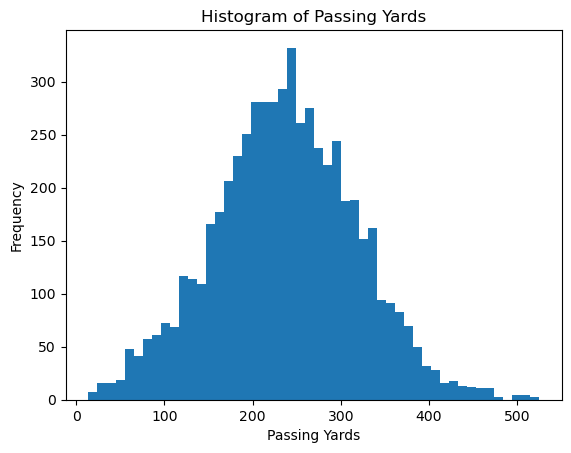

In [89]:
# Identify distribution shape to recreate after we get model results. This looks normal so using our projection for each QB for a week we will use RMSE
# as the standard deviation to create a normal distribution and assign a likelihood to each 
plt.hist(filtered_with_ewma['passing_yards'], bins=50)  # You can adjust the number of bins
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of Passing Yards')
plt.show()

## Exploratory Data Analysis

In [71]:
# Get an overview of the data
filtered_with_ewma.describe().round(2)

,season,week,passing_yards,pass_attempts,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
count,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00,5714.00
mean,2018.65,9.55,236.90,32.18,0.66,31.85,264.31,108.49,0.91,0.75,5.05,2.21,1.46,234.80,0.18,0.66,33.76,280.84,114.50,0.56,0.83,5.41,2.39,1.53,247.70,0.21
std,2.93,5.43,81.27,9.16,0.08,7.50,79.26,36.98,8.03,0.65,2.17,1.27,0.89,66.66,7.01,0.07,5.83,69.62,31.42,7.99,0.68,2.03,1.25,0.82,53.68,6.24
min,2014.00,1.00,14.00,9.00,0.22,6.89,15.00,5.80,-29.73,0.00,0.00,0.00,0.00,22.00,-39.47,0.36,13.93,94.59,31.91,-27.07,0.00,0.00,0.00,0.00,81.57,-28.19
25%,2016.00,5.00,183.00,26.00,0.61,27.25,210.63,83.32,-4.45,0.23,3.49,1.26,0.82,192.31,-4.08,0.61,29.69,231.90,92.25,-4.64,0.25,3.97,1.46,0.92,209.59,-3.80
50%,2019.00,10.00,237.00,32.00,0.66,32.09,261.29,106.75,0.74,0.69,4.83,2.05,1.37,235.83,0.44,0.66,33.49,275.82,111.18,0.85,0.73,5.21,2.24,1.47,245.22,0.28
75%,2021.00,14.00,291.75,38.00,0.71,36.79,314.84,132.32,6.42,1.11,6.38,2.94,2.00,280.01,4.91,0.70,37.48,324.12,134.10,6.03,1.22,6.68,3.12,2.05,283.46,4.45
max,2024.00,22.00,525.00,67.00,1.00,61.00,603.72,250.26,26.29,4.15,14.94,8.25,5.52,483.02,23.10,0.89,61.00,627.07,244.09,27.12,4.01,14.39,8.42,4.96,458.00,20.70


## Modeling w/ Sci-kit Learn

maybe come back to the below cell and figure out how to transform these features into numerical values

In [72]:
# Define the target and features
target = 'passing_yards'
features = filtered_with_ewma.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id'])

In [73]:
# #running on everything to get best params, once I get params take them adn make new model holding out 
# X = filtered_with_ewma.loc[filtered_with_ewma['season'] != 2024, features]
# y = filtered_with_ewma.loc[filtered_with_ewma['season'] != 2024, target]

# # Select columns for one-hot encoding and standard scaling
# categorical_columns = ['roof', 'surface']
# numeric_columns = [item for item in X.columns if item not in ['roof', 'surface']]

# # Create a column transformer for preprocessing (OHE for categorical, SS for numeric)
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(), categorical_columns),
#         ('num', StandardScaler(), numeric_columns)
#     ])

# # Define the parameter grid for tuning
# param_grid = {
#     'num_leaves': [10, 20, 30, 40, 50],
#     'learning_rate': [0.01, 0.03, 0.05, 0.1],
#     'max_depth': [-1, 5, 10, 15],
#     'min_data_in_leaf': [10, 20, 30, 50, 100],
#     'min_split_gain': [0.0, 0.1, 0.2],
#     'subsample_for_bin': [20000, 30000, 40000],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'bagging_fraction': [0.7, 0.8, 0.9],
#     'feature_fraction': [0.7, 0.8, 0.9],
#     'lambda_l1': [0, 0.1, 0.5, 1],
#     'lambda_l2': [0, 0.1, 0.5, 1],
#     'scale_pos_weight': [1, 10, 20],  # for imbalanced datasets
#     'objective': ['regression'],
#     'boosting_type': ['gbdt', 'dart', 'goss'],  # try different boosting types
#     'n_estimators': [500, 1000, 1500],
#     'metric': ['rmse']
# }

# # Instantiate the LGBM model
# model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=42)

# # Define the pipeline with preprocessing and the model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', model)
# ])

# # Set up Bayesian Search using the pipeline
# opt = BayesSearchCV(
#     estimator=pipeline,  # Use the pipeline in Bayesian optimization
#     search_spaces={'regressor__' + k: v for k, v in param_grid.items()},  # Prefix params with 'regressor__'
#     n_iter=50,  # Number of iterations for Bayesian optimization
#     cv=3,
#     random_state=42,
#     verbose=1,
#     n_jobs=-1  # Use parallel processing
# )

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Fit the Bayesian optimization search
# opt.fit(X_train, y_train)

# # Get the best parameters
# best_params = opt.best_params_

# # Save best parameters as a dictionary (without 'regressor__' prefix)
# cleaned_best_params = {k.replace('regressor__', ''): v for k, v in best_params.items()}

In [74]:
# Define the best parameters from Bayesian optimization
best_params = {
    'bagging_fraction': 0.7,
    'boosting_type': 'goss',
    'colsample_bytree': 0.9,
    'feature_fraction': 0.8,
    'lambda_l1': 1,
    'lambda_l2': 0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'metric': 'rmse',
    'min_data_in_leaf': 10,
    'min_split_gain': 0.2,
    'n_estimators': 1000,
    'num_leaves': 10,
    'objective': 'regression',
    'scale_pos_weight': 10,
    'subsample': 0.9,
    'subsample_for_bin': 30000
}


In [75]:
# Use data for all seasons before 2023 for training
X = filtered_with_ewma.loc[filtered_with_ewma['season'] <= 2023, features]
y = filtered_with_ewma.loc[filtered_with_ewma['season'] <= 2023, target]

In [76]:
# The data for 2024 that we will hold out for final testing
X_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, features]
y_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, target]

In [80]:
# Ensure there are no missing values in X or y
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Select columns for one-hot encoding and standard scaling
categorical_columns = ['roof', 'surface']
numeric_columns = [item for item in X.columns if item not in ['roof', 'surface']]

# Create a column transformer for preprocessing (OHE for categorical, SS for numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

# Instantiate the LGBM model with the best parameters
model = lgb.LGBMRegressor(**best_params, random_state=42, verbosity=-1)

# Define the pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Fit the model to all the data through 2023
pipeline.fit(X, y)

# Evaluate the model on the 2024 data
y_pred_2024 = pipeline.predict(X_2024)

# Print results (e.g., performance metrics)
print(f"2024 set performance: RMSE = {mean_squared_error(y_2024, y_pred_2024, squared=False)}")

2024 set performance: RMSE = 18.23482962564805


In [81]:
# Adding identifier columns back after filtering for 2024 data
X_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, features]
X_2024 = X_2024.merge(filtered_with_ewma[['game_id', 'passer_player_name', 'posteam', 'week']], left_index=True, right_index=True)

In [82]:
# Assuming you have a column like 'game_id' that identifies each game
game_id_column = 'game_id'
passer_column = 'passer_player_name'
team_column = 'posteam'
week_column = 'week'

# Preprocess the 2024 data using the pipeline (no need to use 'preprocessor' step directly)
y_pred_2024 = pipeline.predict(X_2024)

# Create a DataFrame to store predictions along with the game identifier
pred_df = pd.DataFrame({
    game_id_column: X_2024[game_id_column].values,
    passer_column: X_2024[passer_column].values,            # Passer name (QB)
    team_column: X_2024[team_column].values,  # Get the game IDs from X_2024
    week_column: X_2024[week_column].values,  #Week
    'true_passing_yards': y_2024.values,                     # Actual target values
    'predicted_passing_yards': y_pred_2024                   # Predicted values
})

pred_df['pass_yards_oe'] = pred_df['true_passing_yards'] - pred_df['predicted_passing_yards']

pred_df.sort_values('pass_yards_oe', ascending = False)

,game_id,passer_player_name,posteam,week,true_passing_yards,predicted_passing_yards,pass_yards_oe
65,2024_03_NE_NYJ,A.Rodgers,NYJ,3,281.0,239.329046,41.670954
24,2024_01_NYJ_SF,A.Rodgers,NYJ,1,167.0,131.284759,35.715241
21,2024_01_MIN_NYG,S.Darnold,MIN,1,208.0,176.318109,31.681891
12,2024_01_HOU_IND,A.Richardson,IND,1,212.0,180.995915,31.004085
20,2024_01_MIN_NYG,D.Jones,NYG,1,186.0,156.956210,29.043790
...,...,...,...,...,...,...,...
40,2024_02_CIN_KC,P.Mahomes,KC,2,151.0,175.422824,-24.422824
8,2024_01_DEN_SEA,B.Nix,DEN,1,138.0,164.620284,-26.620284
31,2024_01_WAS_TB,J.Daniels,WAS,1,184.0,212.705316,-28.705316
63,2024_02_TB_DET,B.Mayfield,TB,2,185.0,222.306808,-37.306808


In [83]:
checker  = pred_df.copy()

In [94]:
# Calculate the percentage over/under for each row
checker["percent_diff"] = (checker["predicted_passing_yards"] - checker["true_passing_yards"]) / checker["true_passing_yards"] * 100

# Separate over and under
over_percentage = (checker["percent_diff"] > 0).sum() / len(checker) * 100
under_percentage = (checker["percent_diff"] < 0).sum() / len(checker) * 100

over_percentage, under_percentage


(34.32835820895522, 65.67164179104478)

In [126]:
pred_df.shape

(67, 7)

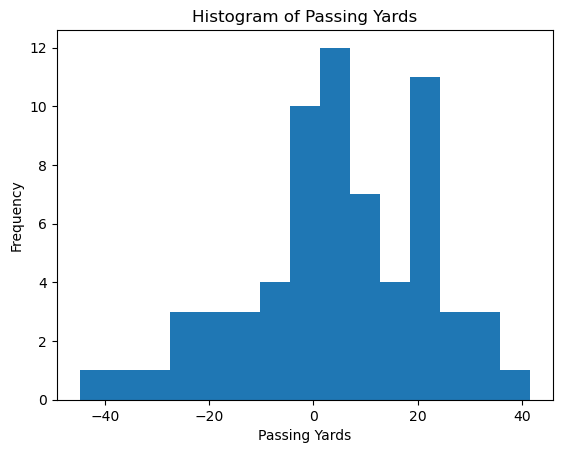

In [128]:
plt.hist(pred_df['pass_yards_oe'], bins=15)  # You can adjust the number of bins
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of Passing Yards')
plt.show()

#Chat GPT convo on boostrapping for distribution- use it!
#also- make sure we setup the span on EWMA's to be max(whateverbasedf['week']) to get proper span number that will increase with week. long term need to find a way to rerun weekly but that is so far away still lol

In [31]:
# Print the features used in the model
print("Features used in the model:")
print(features)

Features used in the model:
Index(['home_flag_passer', 'roof', 'surface',
       'completion_percentage_ewma_passer', 'pass_attempts_ewma_passer',
       'air_yards_ewma_passer', 'yards_after_catch_ewma_passer',
       'epa_ewma_passer', 'interception_ewma_passer', 'qb_hit_ewma_passer',
       'sack_ewma_passer', 'pass_touchdown_ewma_passer',
       'passing_yards_ewma_passer', 'cpoe_ewma_passer', 'home_flag_defense',
       'completion_percentage_ewma_defense', 'pass_attempts_ewma_defense',
       'air_yards_ewma_defense', 'yards_after_catch_ewma_defense',
       'epa_ewma_defense', 'interception_ewma_defense', 'qb_hit_ewma_defense',
       'sack_ewma_defense', 'pass_touchdown_ewma_defense',
       'passing_yards_ewma_defense', 'cpoe_ewma_defense'],
      dtype='object')
